Project Title: Space Object Detection using Deep Learning
Project Description:
This project focuses on detecting different types of space objects using a deep learning model. The model is trained to classify images into four categories: galaxies, asteroids, nebulae, and none (if the image doesn't fit into any of the first three categories). This can be particularly useful for astronomers and space enthusiasts to quickly identify celestial objects from images.

Model Details:
Model Architecture: The deep learning model used in this project is a Convolutional Neural Network (CNN) designed to effectively process and classify images of space objects.
Input: The model takes images resized to 128x128 pixels.
Output: The model outputs the probabilities for each of the four categories (galaxies, asteroids, nebulae, and none), and the highest probability is chosen as the predicted class.
Training Data: The model was trained on a dataset of labeled images of galaxies, asteroids, and nebulae.
Project Components:
Data Preprocessing: Images are resized and normalized to prepare them for the model.
Model Training: The CNN model is trained on the preprocessed images.

# Preprocessing and Augmenting Images


In [ ]:
import os
from PIL import Image
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

target_size = (256, 256)

base_dir = '/content/drive/My Drive/space_objects'
categories = ['nebula', 'asteroids', 'galaxies']
drive_base_dir = '/content/drive/My Drive/space_objects_processed'

# Create an augmentation generator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def preprocess_and_augment_image(image_path, save_dir, category, image_idx):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img) / 255.0

    img_array = np.expand_dims(img_array, axis=0)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    prefix = f"aug_{category}_image_{image_idx}"
    for batch in datagen.flow(img_array, batch_size=1, save_to_dir=save_dir, save_prefix=prefix, save_format='jpeg'):
        break

# Preprocess and augment images for each category
for category in categories:
    print(f"Processing category: {category}")
    category_dir = os.path.join(base_dir, category)
    augmented_dir = os.path.join(drive_base_dir, f"augmented_{category}")

    image_idx = 1
    for img_name in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_name)
        preprocess_and_augment_image(img_path, augmented_dir, category, image_idx)
        image_idx += 1

print("Preprocessing and augmentation complete.")


Processing category: nebula
Processing category: asteroids
Processing category: galaxies
Preprocessing and augmentation complete.


# Data Analysis


Displaying Images

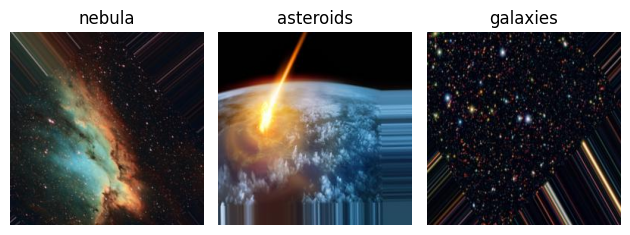

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

drive_base_dir = '/content/drive/My Drive/space_objects_processed'
categories = ['augmented_nebula', 'augmented_asteroids', 'augmented_galaxies']

# Display sample images from each category
fig, axes = plt.subplots(1, 3)
axes = axes.flatten()

for idx, category in enumerate(categories):
    category_dir = os.path.join(drive_base_dir, category)
    img_name = os.listdir(category_dir)[0]
    img_path = os.path.join(category_dir, img_name)
    img = Image.open(img_path).resize((256, 256))
    axes[idx].imshow(img)
    axes[idx].set_title(category.replace('augmented_', ''))
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Class Distribution

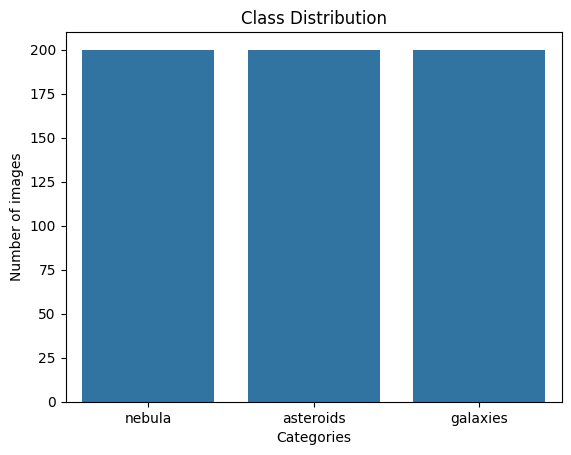

In [ ]:
import seaborn as sns
import numpy as np

labels = []

for category in categories:
    category_dir = os.path.join(drive_base_dir, category)
    label = categories.index(category)
    for img_name in os.listdir(category_dir):
        labels.append(label)

labels = np.array(labels)

# Check class distribution
sns.countplot(x=labels)
plt.xlabel('Categories')
plt.ylabel('Number of images')
plt.title('Class Distribution')
plt.xticks(ticks=range(len(categories)), labels=[cat.replace('augmented_', '') for cat in categories])
plt.show()

Verifying Dimensions

In [ ]:
# Check dimensions of a few images
for category in categories:
    category_dir = os.path.join(drive_base_dir, category)
    img_name = os.listdir(category_dir)[0]
    img_path = os.path.join(category_dir, img_name)
    img = Image.open(img_path)
    print(f"{category}: {img.size}")

consistent_size = True
target_size = (256, 256)

for category in categories:
    category_dir = os.path.join(drive_base_dir, category)
    for img_name in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_name)
        img = Image.open(img_path)
        if img.size != target_size:
            consistent_size = False
            print(f"Inconsistent image size found in {category}: {img_name} with size {img.size}")
            break
    if not consistent_size:
        break

if consistent_size:
    print("All images have the target size:", target_size)
else:
    print("There are images with inconsistent sizes.")

augmented_nebula: (256, 256)
augmented_asteroids: (256, 256)
augmented_galaxies: (256, 256)
All images have the target size: (256, 256)


Renaming Subcategories

In [ ]:
import os

drive_base_dir = '/content/drive/My Drive/space_objects_processed'

categories = ['augmented_nebula', 'augmented_asteroids', 'augmented_galaxies']
new_categories = ['nebula', 'asteroids', 'galaxies']

for i, category in enumerate(categories):
    old_dir = os.path.join(drive_base_dir, category)
    new_dir = os.path.join(drive_base_dir, new_categories[i])
    os.rename(old_dir, new_dir)

print("Subcategories renamed successfully.")


Subcategories renamed successfully.


# Training and Testing Model

In [ ]:
import os
import numpy as np
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
drive_base_dir = '/content/drive/My Drive/space_objects_processed'
categories = ['nebula', 'asteroids', 'galaxies']

data = []
labels = []

for category in categories:
    category_dir = os.path.join(drive_base_dir, category)
    label = categories.index(category)
    for img_name in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_name)
        img = Image.open(img_path).resize((256, 256))
        img_array = np.array(img) / 255.0
        data.append(img_array)
        labels.append(label)

data = np.array(data)
labels = np.array(labels)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),  # Updated input shape
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Fit the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=25,
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32
)

Epoch 1/25
15/15 [==============================] - 111s 7s/step - loss: 1.3426 - accuracy: 0.4104 - val_loss: 1.0343 - val_accuracy: 0.4167
Epoch 2/25
15/15 [==============================] - 104s 7s/step - loss: 0.9647 - accuracy: 0.5479 - val_loss: 0.9107 - val_accuracy: 0.5312
Epoch 3/25
15/15 [==============================] - 101s 7s/step - loss: 0.8495 - accuracy: 0.6187 - val_loss: 0.6935 - val_accuracy: 0.7292
Epoch 4/25
15/15 [==============================] - 102s 7s/step - loss: 0.7661 - accuracy: 0.7042 - val_loss: 0.9610 - val_accuracy: 0.6042
Epoch 5/25
15/15 [==============================] - 100s 7s/step - loss: 0.8510 - accuracy: 0.6083 - val_loss: 0.9293 - val_accuracy: 0.5625
Epoch 6/25
15/15 [==============================] - 99s 7s/step - loss: 0.7816 - accuracy: 0.6583 - val_loss: 0.7326 - val_accuracy: 0.7292
Epoch 7/25
15/15 [==============================] - 114s 7s/step - loss: 0.6746 - accuracy: 0.7312 - val_loss: 0.7790 - val_accuracy: 0.6250
Epoch 8/25
15/

In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

4/4 [==============================] - 10s 3s/step - loss: 0.7184 - accuracy: 0.7750
Validation Loss: 0.718420147895813, Validation Accuracy: 0.7749999761581421


Saving Model

In [ ]:
model.save('/content/drive/My Drive/prev_model.h5')
model.save('/content/drive/My Drive/prev_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
